# Confidence interval of survival data

## Introduction

**Survival analysis** is a branch of statistics that deals with the analysis of time-to-event data, often referred to as 'survival data'.

The **event** can be anything from the death of an organism (hence **survival**), to the failure of a mechanical system, to the recovery of a sick patient.

A **confidence interval** in survival analysis gives a range of values, derived from the data, that is likely to contain the true value of an unknown population parameter. In the context of survival analysis, a confidence interval might be used to describe the uncertainty around a survival time estimate.

## Survival data

### The `lifelines` library

In Python, the [`lifelines` library](https://lifelines.readthedocs.io/en/stable/index.html) is commonly used for survival analysis. It provides a simple and intuitive API for fitting survival models, and also includes functions for visualizing survival data. Here's a basic example of how we might calculate a confidence interval for a survival function estimate using the `KaplanMeierFitter` class in lifelines:

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

print('lifelines version:', lifelines.__version__)

lifelines version: 0.29.0


In [43]:
from lifelines import KaplanMeierFitter

# Assume we have some survival data in the following two lists:
# `durations` is a list of durations until the event or censorship
# `event_observed` is a binary list where 1 indicates the event, 
# i.e., death, occurred, and 0 indicates censorship

# example of the survival data from pages 47-48 of the book Intuitive Biostatistics
durations       = [4.07, 6.54, 1.39, 6.17, 5.89, 4.76, 3.67]
event_observed  = [1   , 0   , 1   , 0   , 1   , 1   , 0   ]

# we create a dataframe with those data
data = pd.DataFrame(
    {
        'YEARS': durations,
        'EVENT': event_observed,
    }
)

# sorted durations
data.sort_values(by='EVENT')

,YEARS,EVENT
1,6.54,0
3,6.17,0
6,3.67,0
0,4.07,1
2,1.39,1
4,5.89,1
5,4.76,1


In [44]:
# Create a fitter instance
kmf = KaplanMeierFitter()

# Fit the data to the model
kmf.fit(
    durations=durations,
    event_observed=event_observed,
)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

The `kmf._median` attribute gives us the **median survival time**. In the context of survival analysis, the median survival time is the smallest time at which the survival probability drops to 0.5 or below. In other words, it's the time by which half of the population has experienced the event of interest.

In [45]:
print("Median survival time:", kmf.median_survival_time_)

Median survival time: 5.89


Please note that the median survival time might be `inf` (infinity) for some datasets. This happens when the survival function never goes below 0.5, which means that more than half of the population survives till the end of the observation period. In such cases, the median survival time is undefined and is conventionally considered to be infinite.

The survival function estimate and its confidence intervals can be accessed with:

In [46]:
kmf.survival_function_

,KM_estimate
timeline,
0.00,1.000000
1.39,0.857143
3.67,0.857143
4.07,0.685714
4.76,0.514286
5.89,0.342857
6.17,0.342857
6.54,0.342857


In [47]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.00,1.000000,1.000000
1.39,0.334054,0.978561
3.67,0.334054,0.978561
4.07,0.212797,0.912112
4.76,0.117760,0.813249
5.89,0.048108,0.685484
6.17,0.048108,0.685484
6.54,0.048108,0.685484


This gives us the survival function estimates along with their confidence intervals. The first table corresponds to the "% survival", and the second table to the "lower limit" and "upper limit" in the table 5.3 of the book.

Remember, the interpretation of confidence intervals in the context of survival data is the same as in other areas of statistics. A 95% confidence interval means that if we were to repeat our study many times, we would expect the true survival function to fall within our estimated interval in 95% of studies.

The `lifelines` API provides many other utilities, for example the function called `survival_table_from_events` is used to create a survival table given some durations and censoring vectors. The survival table provides a summary of the number of individuals at risk, the number of events, and the number of censored observations at each unique time point in the data.

In [48]:
from lifelines.utils import survival_table_from_events

# Create the survival table
table = survival_table_from_events(durations, event_observed)

print(table)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.00            0         0         0         7        7
1.39            1         1         0         0        7
3.67            1         0         1         0        6
4.07            1         1         0         0        5
4.76            1         1         0         0        4
5.89            1         1         0         0        3
6.17            1         0         1         0        2
6.54            1         0         1         0        1


This prints a DataFrame that includes the following columns:

- _removed_ is the number of individuals that had an event or were censored at each time point.
- _observed_ is the number of individuals that had an event at each time point.
- _censored_ is the number of individuals that were censored at each time point.
- _entrance_ is the number of individuals that entered the risk set at each time point. This is usually 0 for all time points except the first one.
- _at_risk_ is the number of individuals that are at risk of having an event at each time point.

And `lifelines.utils.survival_events_from_table` is the inverse of the function survival_table_from_events:

In [49]:
# need to create new columns in order to prepare a lifelines Table
data['observed'] = data['EVENT'] == 1
data['censored'] = data['EVENT'] == 0

# Transforming survival-table data into lifelines format
from lifelines.utils import survival_events_from_table

T, E, W = survival_events_from_table(
    data.set_index('YEARS'),
    observed_deaths_col='observed',
    censored_col='censored')

print("Durations of observation:", T)

Durations of observation: [4.07 6.54 1.39 6.17 5.89 4.76 3.67]


### Plotting the survival function

We can then plot the survival function with confidence intervals using `kmf.plot_survival_function()`.

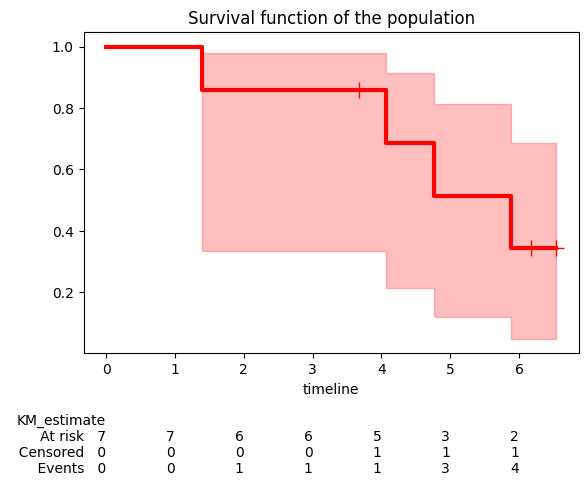

In [50]:
# let's see how it looks
plt.figure(figsize=(6,5))

kmf.plot(
    show_censors=True,
    ci_show=True,
    legend=False,
    lw=3,
    c='red',
    at_risk_counts=True, # adds summary tables under the plot
)
plt.ylabel('Suvival probability estimate')
plt.title('Survival function of the population');

`kmf.plot_survival_function()` plots the Kaplan-Meier estimate of the survival function. The y-axis represents the probability that the event of interest has not yet occurred, while the x-axis represents time.

The shaded area around the survival function line represents the confidence interval. By default, it's a 95% confidence interval, meaning we are 95% confident that the true survival function lies within this area.

## Kaplan-Meier estimator

### Fraction surviving

The **fraction surviving**, often represented as S(t), is a fundamental concept in survival analysis. It represents the probability that an individual survives from the time origin (t=0) to a specified future time t.

The survival function S(t), also known as the probability that life is longer than t, is given by $S(t) = P(T > t)$, where T is the random lifetime taken from the population.

In the context of survival analysis, "surviving" doesn't necessarily mean "not dying." Instead, it means "not experiencing the event of interest." The event could be anything: death, failure of a machine, recovery from a disease, etc.

Now, let's consider the example of the 7 individuals in the previous study. Let's focus on the 3 first events:

1. At time t1, one event (death) occurs. So, the fraction surviving drops by 1/7 (since all 7 individuals were at risk at this time). The survival probability at time t1 is thus $S(t_1) = 6/7$.
2. At time t2, one individual is censored. This means they leave the study or the study ends before they have the event. Censoring does not affect the survival probability, so $S(t_2) = S(t_1) = 6/7$.
3. At time t3, another event occurs. Now, only 5 individuals were at risk (since one event occurred at t1, reducing the at-risk group to 6, and one individual was censored at t2, further reducing the at-risk group to 5), so the fraction surviving drops by 1/5. The survival fraction at time t3 is thus $S(t_3) = S(t_2) \times (1 - 1/5) = (6/7)(4/5)$. And so on.

We can compute the surviving fractions manually as follows:

In [51]:
print(6/7)
print(6/7 * 4/5)
print(6/7 * 4/5 * 3/4)

0.8571428571428571
0.6857142857142857
0.5142857142857142


### Survival function

In survival analysis, the survival function S(t) is often estimated using the product of conditional survival probabilities. This is the basis for the Kaplan-Meier estimator, which is one of the most commonly used methods in survival analysis.

The Kaplan-Meier estimate of the survival function at time t is given by:

$$\hat{S}(t) = \prod_{k \mid t_k \le{t}} \left(1 - \frac{d_k}{n_k} \right)$$

where:

- The product is over all times $t_i$ up to and including $t$ where at least one event occurred.
- $d_k$ is the number of events that occurred at time $t_k$.
- $n_k$ is the number of individuals at risk at time $t_k$, i.e., the number of individuals who have not yet had an event and have not been censored before time $t_k$.

This product ensures that the survival function estimate is properly adjusted at each time an event occurs, taking into account the decreasing number of individuals at risk.

Also note that

$$\hat{S}(t_j) = \prod_{i=1}^j\frac{n_i - d_i}{n_i} = \frac{n_j - d_j}{n_j} \times \prod_{i=1}^{j-1} \frac{n_i - d_i}{n_i} = \frac{n_j - d_j}{n_j} \times \hat{S}(t_{j-1})$$

In [52]:
import numpy as np

# convert back from Series to array
durations = data['YEARS'].to_numpy()
event_observed = data['EVENT'].to_numpy()

# Sort durations and event_observed by durations
sort_indices = np.argsort(durations)
durations_sorted = durations[sort_indices]
events_sorted = event_observed[sort_indices]

n_at_risk = len(durations_sorted)  # initial number at risk
survival_prob = 1.0  # initial survival probability

for i in range(len(durations_sorted)):
    if events_sorted[i]:  # if event occurred
        survival_prob *= (1 - 1/n_at_risk)
    print(f"Time: {durations_sorted[i]}, Survival fraction S(t): {survival_prob}")
    n_at_risk -= 1  # decrease number at risk

Time: 1.39, Survival fraction S(t): 0.8571428571428572
Time: 3.67, Survival fraction S(t): 0.8571428571428572
Time: 4.07, Survival fraction S(t): 0.6857142857142858
Time: 4.76, Survival fraction S(t): 0.5142857142857143
Time: 5.89, Survival fraction S(t): 0.3428571428571429
Time: 6.17, Survival fraction S(t): 0.3428571428571429
Time: 6.54, Survival fraction S(t): 0.3428571428571429


In [53]:
# for example for t=4.07, since no event were observed
# at the second time point t=3.67 (censored)
S3 = (1 - 1/7) * (1 - 0/6) * (1 - 1/5)

print(f"Time: {4.07}, Survival fraction S(t): {S3}")

Time: 4.07, Survival fraction S(t): 0.6857142857142858


We won't rewrite the entire `lifelines` library, but here is an example of how we could have written the Kaplan-Meier survival function:

In [54]:
def kaplan_meier(durations, event_observed):
    """
    Estimates the survival function using the Kaplan-Meier method.

    Args:
        durations: A numpy array of event times.
        event_observed: A numpy array of indicators (1 for event, 0 for censoring) 
        at each time point.

    Returns:
        A tuple containing three numpy arrays:
            - survival_probsorted: Estimated survival probabilities at each time point (sorted).
            - events_sorted: Unique event (sorted).
            - durations_sorted: Unique event times (sorted).
            
    """

    # Sort durations and event_observed by durations
    sort_indices = np.argsort(durations)
    durations_sorted = np.array(durations)[sort_indices]
    events_sorted = np.array(event_observed)[sort_indices]

    # Initialize variables
    n_at_risk = len(durations_sorted)  # initial number at risk
    survival_prob_sorted = np.ones_like(durations_sorted)  # initial survival probabilities

    for i in range(len(durations_sorted)):
        if events_sorted[i] == 1:  # if event occurred
            survival_prob_sorted[i:] *= (1 - 1/n_at_risk)
        n_at_risk -= 1  # decrease number at risk

    return survival_prob_sorted, events_sorted, durations_sorted

In [55]:
print(kaplan_meier(data['YEARS'], data['EVENT']))

(array([0.85714286, 0.85714286, 0.68571429, 0.51428571, 0.34285714,
       0.34285714, 0.34285714]), array([1, 0, 1, 1, 1, 0, 0], dtype=int64), array([1.39, 3.67, 4.07, 4.76, 5.89, 6.17, 6.54]))


## Confidence interval

### The basics

The confidence interval for the survival function at each time point is typically calculated in using the [Greenwood's formula](https://bookdown.org/sestelo/sa_financial/pointwise-confidence-interval-for-st.html), which provides an estimate of the variance of the survival function. The formula for the variance at time $t$ using the so-called "linear" or "plain" method is:

$$s^2_{S(t)} = S^2(t) \times \sum_{t_k \le{t}} \frac{d_k}{n_k (n_k - d_k)}$$

where:

- $S(t)$ is the Kaplan-Meier estimate of the survival function up to time $t$.
- The sum is over all times $t_k$ up to and including $t$ where at least one event occurred.
- $d_k$ is the number of events that occurred at time $t_k$
- $n_k$ is the number of individuals at risk at time $t_k$.

Therefore, assuming that the sample follow a Normal distribution, so that $S(t) \pm z^\ast \times s_{S(t)}$, the confidence interval, can be determinted:

$$\text{IC}^{0.95}_{S(t)} = S(t) \pm 1.96 \times s_{S(t)}$$

where $z^\ast$ is the z-score or critical value for the desired confidence level (for example, z = 1.96 for a 95% confidence interval), and $s_{S(t)}$ the *standard error* (it will be discussed in more details in later chapters). The common practice is to clip the interval at $[0,1]$.

Note that these calculations assume that the number of events at each time point and the number of individuals at risk are _large enough_ for the Central Limit Theorem to hold. If these numbers are small, the confidence intervals may not be accurate.

### Step-by-step example

The z-values, also known as **z-scores**, correspond to the number of standard deviations away from the mean in a standard normal distribution. They are used to calculate confidence intervals in statistics, notably using **critical z-values**. These values are derived from the standard normal distribution and are used to calculate the margin of error.

In [56]:
from scipy.stats import norm

# For a 99% confidence level
z_99 = norm.ppf(0.995)  # Two-tailed test, so we use 0.995 instead of 0.99
print(f"Z-value for 99% confidence = {z_99:.6f}")

# For a 95% confidence level
z_95 = norm.ppf(0.975)  # Two-tailed test, so we use 0.975 instead of 0.95
print(f"Z-value for 95% confidence = {z_95:.6f}")

Z-value for 99% confidence = 2.575829
Z-value for 95% confidence = 1.959964


Let's take the first events in our example to show how we construct the margin of error using the Greenwood's formula. We simply enter the values for $n$ and $d$.

In [57]:
# breakdown calculation for the first event
S1 = (1 - 1/7)
component_t1 = 1/(7*(7-1))
cumsum_component_t1 = component_t1
SE1 = S1 * np.sqrt(cumsum_component_t1)
print(f"S(t1) = {S1:.4f}")
print(f"Greenwood variance component at t1 = {component_t1:.3f}")
print(f"Cumulative sum up to t1 = {cumsum_component_t1:.3f}")
print(f"s_S(t1) = {SE1:.3f}")
print(f"The confidence interval (plain type) limits at t1 are \
[{S1 - 1.96*SE1:.3f} - {S1 + 1.96*SE1:.3f}]")

S(t1) = 0.8571
Greenwood variance component at t1 = 0.024
Cumulative sum up to t1 = 0.024
s_S(t1) = 0.132
The confidence interval (plain type) limits at t1 are [0.598 - 1.116]


When no event is observed, $d=0$ and $e=0$, so that the sum of $e$ doesn't change nor the survival function or its standard error.

In [58]:
# breakdown calculation for the third event
S3 = (1 - 1/7) * (1 - 0/6) * (1 - 1/5)
component_t3 = 1 / (5*(5 - 1))
cumsum_component_t3 = component_t1 + 0 + component_t3
SE3 = S3 * np.sqrt(cumsum_component_t3)
print(f"S(t3) = {S3:.4f}")
print(f"Greenwood variance component at t3 = {component_t3:.3f}")
print(f"Cumulative sum up to t3 = {cumsum_component_t3:.3f}")
print(f"s_S(t3) = {SE3:.3f}")
print(f"The confidence interval (plain type) limits at t3 are \
[{S3 - 1.96*SE3:.3f} - {S3 + 1.96*SE3:.3f}]")

S(t3) = 0.6857
Greenwood variance component at t3 = 0.050
Cumulative sum up to t3 = 0.074
s_S(t3) = 0.186
The confidence interval (plain type) limits at t3 are [0.321 - 1.051]


In [59]:
# breakdown calculation for the 4th event
S4 = (1 - 1/7) * (1 - 0/6) * (1 - 1/5) * (1 - 1/4)
component_t4 = 1 / (4* (4 - 1))
cumsum_component_t4 = component_t1 + 0 + component_t3 + component_t4
SE4 = S4 * np.sqrt(cumsum_component_t4)
print(f"S(t4) = {S4:.4f}")
print(f"Greenwood variance component at t4 = {component_t4:.3f}")
print(f"Cumulative sum up to t4 = {cumsum_component_t4:.3f}")
print(f"s_S(t4) = {SE4:.3f}")
print(f"The confidence interval (plain type) limits at t4 are \
[{S4 - 1.96*SE4:.3f} - {S4 + 1.96*SE4:.3f}]")

S(t4) = 0.5143
Greenwood variance component at t4 = 0.083
Cumulative sum up to t4 = 0.157
s_S(t4) = 0.204
The confidence interval (plain type) limits at t4 are [0.115 - 0.914]


So that we obtain the following table:

| time to event | at risk (n) | observed (d) | S(t)   | d/(n(n-d)) | cumsum | s_S(t) | LCL   | UCL   |
| ------------- | ----------- | ------------ | ------ | ---------- | ------ | ------ | ----- | ----- |
| 1.39          | 7           | 1            | 0.8571 | 0.024      | 0.024  | 0.132  | 0.598 | 1.116 |
| 3.67          | 6           | 0            | 0.8571 | 0          | 0.024  | 0.132  | 0.598 | 1.116 |
| 4.07          | 5           | 1            | 0.6857 | 0.050      | 0.074  | 0.186  | 0.321 | 1.051 |
| 4.76          | 4           | 1            | 0.5143 | 0.083      | 0.157  | 0.204  | 0.115 | 0.914 |

### Log survival

In survival analysis, confidence intervals are often calculated on the log scale, where the _complementary log-log transformation_ $v(t) = \log(-\log S(t))$ is used a few reasons:

1. Symmetry: survival probabilities are bound between 0 and 1, and their distribution can be skewed, especially when probabilities are close to the boundaries. Taking the logarithm helps to symmetrize the distribution, which is a key assumption for the calculation of confidence intervals.
2. Stabilizing variance: the variance of survival probabilities can change over time, and it can be particularly high when probabilities are close to 0 or 1. The log transformation can help to stabilize the variance, making the statistical analysis more reliable.
3. Multiplicative effects: in many cases, particularly in the context of survival analysis, the effects are multiplicative rather than additive. The log transformation converts *multiplicative effects* on the original scale to *additive effects* on the log scale, which simplifies the analysis: $\log {S(t)} = \log \prod (1 - \frac{d_k}{n_k}) = \sum{\log (1 - \frac{d_k}{n_k})}$.
4. Avoiding impossible values: when calculating confidence intervals for survival probabilities, it's possible to get values that fall outside the range $[0, 1]$, which doesn't make sense for probabilities. The log transformation followed by exponentiation (when calculating the confidence interval bounds) ensures that the confidence intervals fall within the appropriate range.

The variance for the transformed values is calculated using a specialized formula derived from Greenwood's formula and a technique called the [delta method](https://en.wikipedia.org/wiki/Delta_method). While the derivation involves some calculus (function derivatives), the resulting formula is straightforward to use:

$$
s^2_{v(t)} = \frac{\sum_{t_k \le t} \frac{d_k}{n_k(n_k - d_k)}}{\left( \sum_{t_k \le t} \log \frac{n_k - d_k}{n_k} \right)^2}
$$

where $t_k$ are the distinct event times, $d_k$ is the number of events at time $t_k$, and $n_k$ is the number of individuals at risk at time $t_k$. Note that the numerator in the formula for  $s_{v(t)}$ is identical to the summation term in Greenwood's formula, which represents the cumulative sum of estimated hazard increments. So that the confidence interval on the log-log scale is $\text{CI}_{v(t)} = v(t) \pm z^\ast \times s_{v(t)}$.

Finally, we can transform back to the original scale, i.e., the scale of the survival function, by exponentiating the lower and upper limits of the confidence interval for the log survival function:

$$
\begin{aligned}
\text{IC}^{0.95}_{S(t)} &= \exp (-\exp \left(\text{CI}^{0.95}_{v(t)} \right)) \\
&= \exp (-\exp \left( log(-log(S(t))) \pm 1.96 \times s_{v(t)} \right)) \\
&= S(t)^{\exp(\pm 1.96 \times s_{v(t)})}
\end{aligned}
$$

Let's fill the formula with the values from the first events in our example.

In [60]:
# breakdown calculation for the first and second events
denominator_component_t1 = np.log((7-1)/7)
cumsum_denominator_t1 = denominator_component_t1
s_vt1 = np.sqrt(cumsum_component_t1 / cumsum_denominator_t1**2)
print(f"Log-survival increment at t1 = {denominator_component_t1:.3f}")
print(f"Log-log variance scaling factor at t1 = {cumsum_denominator_t1:.3f}")
print(f"s_v(t1) = {s_vt1:.3f}")
print(f"The confidence interval (log-log transformation) limits at t1 are \
[{S1**np.exp(1.96*s_vt1):.4f} - {S1**np.exp(-1.96*s_vt1):.4f}]")

Log-survival increment at t1 = -0.154
Log-log variance scaling factor at t1 = -0.154
s_v(t1) = 1.001
The confidence interval (log-log transformation) limits at t1 are [0.3340 - 0.9786]


Note that when $d=0$, then $l=\log(n/n)=\log(1)=0$, so the all the values for the second time-point are identical to the first ones.

In [61]:
# breakdown calculation for the third event
denominator_component_t3 = np.log((5-1)/5)
cumsum_denominator_t3 = denominator_component_t1 + 0 + denominator_component_t3
s_vt3 = np.sqrt(cumsum_component_t3 / cumsum_denominator_t3**2)
print(f"Log-survival increment at t3 = {denominator_component_t3:.3f}")
print(f"Log-log variance scaling factor at t3 = {cumsum_denominator_t3:.3f}")
print(f"s_v(t3) = {s_vt3:.3f}")
print(f"The confidence interval (log-log transformation) limits at t3 are \
[{S3**np.exp(1.96*s_vt3):.4f} - {S3**np.exp(-1.96*s_vt3):.4f}]")

Log-survival increment at t3 = -0.223
Log-log variance scaling factor at t3 = -0.377
s_v(t3) = 0.720
The confidence interval (log-log transformation) limits at t3 are [0.2128 - 0.9121]


In [62]:
# breakdown calculation for the 4th event
denominator_component_t4 = np.log((4-1)/4)
cumsum_denominator_t4 = denominator_component_t1 + 0 + denominator_component_t3 + denominator_component_t4
s_vt4 = np.sqrt(cumsum_component_t4 / cumsum_denominator_t4**2)
print(f"Log-survival increment at t4 = {denominator_component_t4:.3f}")
print(f"Log-log variance scaling factor at t4 = {cumsum_denominator_t4:.3f}")
print(f"s_v(t4) = {s_vt4:.3f}")
print(f"The confidence interval (log-log transformation) limits at t4 are \
[{S4**np.exp(1.96*s_vt4):.4f} - {S4**np.exp(-1.96*s_vt4):.4f}]")

Log-survival increment at t4 = -0.288
Log-log variance scaling factor at t4 = -0.665
s_v(t4) = 0.596
The confidence interval (log-log transformation) limits at t4 are [0.1178 - 0.8133]


These calculations lead to the final table:

| time to event | n | d | S(t)   | e     | cumsum(e) | log((n-d)/n) | cumsum | s_v(t) | LCL    | UCL    |
| ------------- | - | - | ------ | ----- | --------- | ------------ | ------ | ------ | ------ | ------ |
| 1.39          | 7 | 1 | 0.8571 | 0.024 | 0.024     | -0.154       | -0.154 | 1.001  | 0.3340 | 0.9786 |
| 3.67          | 6 | 0 | 0.8571 | 0     | 0.024     | 0            | -0.154 | 1.001  | 0.3340 | 0.9786 |
| 4.07          | 5 | 1 | 0.6857 | 0.050 | 0.074     | -0.223       | -0.377 | 0.720  | 0.2128 | 0.9121 |
| 4.76          | 4 | 1 | 0.5143 | 0.083 | 0.157     | -0.288       | -0.665 | 0.596  | 0.1178 | 0.8133 |

### Process automation with scripts

While libraries like `lifelines` offer convenient functions for various statistical analyses, understanding the underlying calculations is valuable. This section dives into creating one script to calculate confidence intervals.

In [63]:
from scipy.stats import norm

def greenwood_confidence_interval(
        survival_prob_sorted, event_indicators_sorted, alpha=.05, method="log-log"):
    """
    Calculates the confidence intervals, plain and log-log, for a Kaplan-Meier curve, 
    assuming pre-sorted data, using the Greenwood variance estimate.

    Args:
        survival_prob_sorted: A numpy array of estimated survival probabilities 
        at each time point (assumed to be sorted).
        event_indicators: A numpy array of indicators (1 for event, 0 for censoring) 
        at each time point (assumed to be sorted).
        alpha: significance level (e.g., 0.05 for 95% confidence interval)
        method: if not "log-log" then the function return the "plain" 
        or "linear" confidence intervals

    Returns:
        A tuple containing two numpy arrays:
            standard error using the given method (log-log by default) and alpha (95% by default).
            lower and upper bounds of the confidence interval using the given method and alpha.
    """

    # Use inverse normal cumulative distribution for z-score
    z = norm.ppf(1 - alpha/2)  # Two-tailed test

    # first we calculate the term in the sum for the variance;
    # di is indeed the array `event_indicators_sorted`
    
    # we need the number of individual at risk remaining at each time point
    n = len(d:=event_indicators_sorted)+1 - np.cumsum(np.ones_like(d))

    # and then compute the cumulative sums of the terms
    sum_e = np.cumsum(d / (n * (n-d)))

    # then we compute the cumulative sums of the log of the term for the log-log method
    sum_l = np.cumsum(np.log((n - d)/n))
    
    # if the method is different from "log-log", then we return the "plain" or "linear" SE and CI
    if method != "log-log":
        SE = survival_prob_sorted * np.sqrt(sum_e)
        return SE, np.array([survival_prob_sorted - z*SE, survival_prob_sorted + z*SE])
    else:
        SE = np.sqrt(sum_e / sum_l**2)
        return SE, np.array(
            [survival_prob_sorted**np.exp(1.96*SE), survival_prob_sorted**np.exp(-1.96*SE)])

In [64]:
# Example usage (assuming we have our Kaplan-Meier estimates)
survival_prob_sorted, event_indicators_sorted, _ = kaplan_meier(data['YEARS'], data['EVENT'])

SE, (lower_bound, upper_bound) = greenwood_confidence_interval(
    survival_prob_sorted, event_indicators_sorted)

# lower_bound and upper_bound contain the confidence interval for each time point
print(lower_bound)
print(upper_bound)

[0.33404067 0.33404067 0.21278887 0.11775418 0.04810556 0.04810556
 0.04810556]
[0.97856182 0.97856182 0.91211394 0.81325222 0.68548852 0.68548852
 0.68548852]


## Conclusion

Survival analysis is a branch of statistics that deals with time-to-event data. It's used in a variety of fields, from medical research to machine failure analysis. The `lifelines` library provides a high-level, intuitive API for survival analysis in Python, making it accessible for both statisticians and non-statisticians.

Here are some key points about `lifelines`:

- Easy to use: it provides a simple and intuitive interface for fitting survival models, calculating survival probabilities, and visualizing survival data.
- Comprehensive: it includes a variety of survival models, such as the Kaplan-Meier estimator and the Cox proportional hazards model, allowing us to choose the model that best fits our data.
- Handles censoring: One of the key challenges in survival analysis is dealing with censored data. It handles right-censored data natively, making it easier to work with this type of data.
- Confidence intervals: it automatically calculates confidence intervals for survival function estimates, providing a measure of uncertainty around these estimates.
- Plotting capabilities: it includes functions for plotting survival functions and hazard functions, providing a visual way to understand our survival data.

In this chapter, we've seen how to use lifelines to calculate survival probabilities, create survival tables, and estimate confidence intervals. We've also discussed some of the theory behind survival analysis, including the concept of "at risk" individuals and the calculation of survival fractions.

In conclusion, lifelines is a powerful tool for survival analysis in Python. Whether we're a researcher studying patient survival times, a data scientist predicting customer churn, or an engineer analyzing machine failure times, lifelines has the tools we need to analyze our data and draw meaningful conclusions.

## Cheat sheet

This cheat sheet provides a quick reference for essential code snippets used in this chapter.

### Survival function

```python
import lifelines

# Create a fitter instance
kmf = KaplanMeierFitter()

# Fit the data to the model
kmf.fit(
    durations=durations,
    event_observed=event_observed,)

# Median survival time
kmf.median_survival_time_

# Survival function
kmf.survival_function_

# Survival table
from lifelines.utils import survival_table_from_events

survival_table_from_events(durations, event_observed)

# Survival events
from lifelines.utils import survival_events_from_table

# time, events, censored
T, E, W = survival_events_from_table(
    data.set_index('YEARS'),
    observed_deaths_col='observed',
    censored_col='censored')
```

### Confidence interval

```python
# Confidence interval
kmf.confidence_interval_
```

### Kaplan-Meier plot

```python
# Plotting the survival function
kmf.plot(
    show_censors=True,
    ci_show=True,
    at_risk_counts=True, # add summary tables under the plot
)
```

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [65]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'pandas', 'lifelines', 'scipy', 'statsmodels', 'matplotlib']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.7-------------

numpy: 1.26.4
pandas: 2.2.2
lifelines: 0.29.0
scipy: 1.14.1
statsmodels: 0.14.2
matplotlib: 3.9.2
